Questions:
  * Is the radiation pattern of our antennas almost isotropic? What is the impact on link symmetry?
  * How big is the transitional region? The testbed may be too small to evaluate it
  * How do you pick the right configuration?
  * Hardware variation?
  
  

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from twophase import plot_antenna_pattern, plot_benefit,coverage,polarunion,interf_benefit,telos_gains,plot_telos_pattern,telos_interf_benefit
from twophase import plot_interf_benefit, compute_directional_benefit, compute_directional_benefit
from ingest_ab import process_file 
from directional_benefit import plot_directional_benefit
import itertools

import matplotlib
matplotlib.matplotlib_fname()
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['savefig.bbox'] = 'tight'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
fn = '/Users/ochipara/Working/DirectionalAntennas/data/testbed/tx_temporal/AB_Channel11_Power7_MoteA/2016-10-05_NODE0.csv'
df = pd.DataFrame.from_csv(fn)
df = df[['phase1', 'phase2', 'rssi']]
print('building group')
g = df.groupby(['phase1', 'phase2'])

OSError: File b'/Users/ochipara/Working/DirectionalAntennas/data/testbed/tx_temporal/AB_Channel11_Power7_MoteA/2016-10-05_NODE0.csv' does not exist

In [11]:
m_rssi = g.rssi.mean()
m_count = g.rssi.count()

In [12]:
tbl = pd.concat([m_rssi, m_count], axis=1, keys=['rssi', 'count'])

In [6]:
C = max(tbl['count'].values)

adjusted_rssi = []
for index,values in tbl.iterrows():
    rssi = values['rssi']
    count = values['count']
    a = rssi * count / C
    b = (-100) * (C - count)/ C
    #print(index, rssi, count, C, a + b )
    adjusted_rssi.append(a + b)

tbl['adjusted_rssi'] = adjusted_rssi
tbl
#tbl['seq'] = list(range(len(tbl)))
#tbl.set_index('seq', append=True)
# tbl = tbl.reset_index()
# t1 = tbl[tbl.phase2 == 0]
# t1
tbl

rssi  count  adjusted_rssi
phase1 phase2                                 
0      0      -91.619048    105     -99.837158
       32     -90.573095   2401     -95.811621
       64     -87.666730   5260     -87.995374
       96     -85.094007   5340     -85.270540
       128    -84.159345   5372     -84.253146
       160    -85.057325   5338     -85.239822
       192    -87.621413   5193     -88.104737
       224    -90.872373   3236     -94.534234
32     0      -90.605072   3312     -94.242043
       32     -91.458537    205     -99.675981
       64     -89.969107   3593     -93.330681
       96     -86.821617   5320     -87.026462
       128    -84.147915   5395     -84.174315
       160    -83.764234   5357     -83.905440
       192    -84.752738   5387     -84.800703
       224    -87.814794   5259     -88.141747
64     0      -87.114167   5273     -87.426536
       32     -90.381217   3418     -93.916173
       64     -91.363296    267     -99.573279
       96     -90.005549   3424     -93.667469
       128    -86.156804   5306     -86.407846
       160    -84.024209   5370     -84.124722
       192    -83.496565   5385     -83.554589
       224    -84.635512   5339     -84.820318
96     0      -84.740262   5340     -84.920984
       32     -87.246051   5255     -87.597705
       64     -90.222474   3524     -93.623982
       96     -91.339286    224     -99.641007
       128    -89.795308   3879     -92.675056
       160    -86.604344   5295     -86.874537
...                  ...    ...            ...
128    64     -87.707812   5274     -88.003516
       96     -85.179564   5363     -85.292006
       128    -84.214962   5387     -84.264619
       160    -85.138228   5339     -85.316987
       192    -87.668008   5217     -88.094745
       224    -90.894930   3274     -94.483716
160    0      -90.644908   3309     -94.271651
       32     -91.515419    227     -99.643597
       64     -89.986787   3557     -93.409141
       96     -86.828134   5289     -87.108438
       128    -84.166759   5391     -84.204848
       160    -83.783029   5374     -83.873057
       192    -84.774495   5348     -84.932272
       224    -87.819436   5217     -88.240933
192    0      -87.091336   5321     -87.289600
       32     -90.407823   3477     -93.828275
       64     -91.430508    295     -99.532198
       96     -89.996827   3467     -93.582346
       128    -86.140109   5303     -86.399149
       160    -84.047203   5381     -84.115100
       192    -83.514031   5381     -83.584197
       224    -84.663579   5398     -84.680607
224    0      -84.769288   5379     -84.839748
       32     -87.251376   5267     -87.574574
       64     -90.216352   3596     -93.489637
       96     -91.599099    222     -99.654885
       128    -89.793112   3833     -92.760363
       160    -86.590216   5315     -86.811066
       192    -84.229645   5404     -84.229645
       224    -83.870101   5358     -84.007402

[64 rows x 3 columns]

In [7]:
node0_antm_df = pd.DataFrame.from_csv('/Users/ochipara/Working/DirectionalAntennas/data/testbed/antennapatterns/MoteB_AntennaM/2016-09-24_NODE0.csv')

motea_antm_df = {}
telosb_df = {}

for node in range(16):
    motea_antm_df[node] = pd.DataFrame.from_csv('/Users/ochipara/Working/DirectionalAntennas/data/testbed/antennapatterns/MoteD_AntennaM/2016-09-24_NODE%d.csv' % node)
    telosb_df[node] = pd.DataFrame.from_csv('/Users/ochipara/Working/DirectionalAntennas/data/testbed/antennapatterns/TelosB/2016-09-25_NODE%d.csv' % node)

telosb0_df = telosb_df[0]

-89 -57
-89 -57
-89 -57
-89 -57
-89 -57
-89 -57


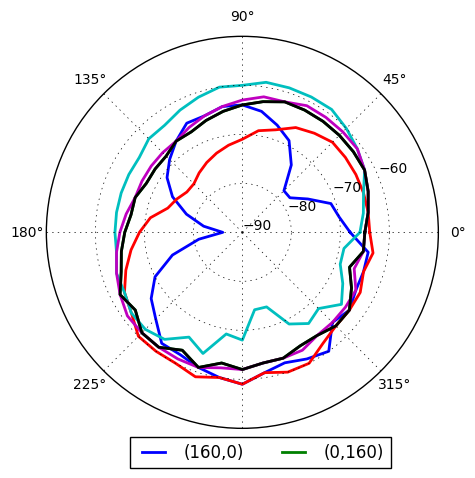

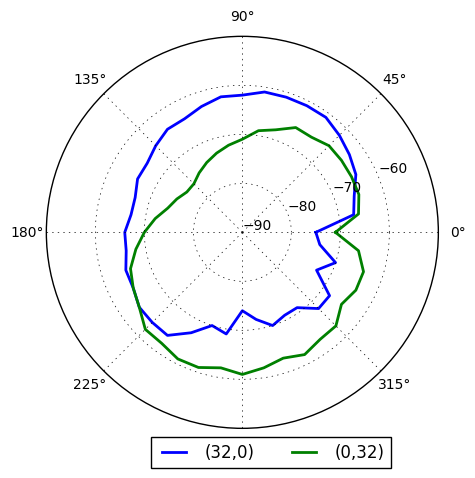

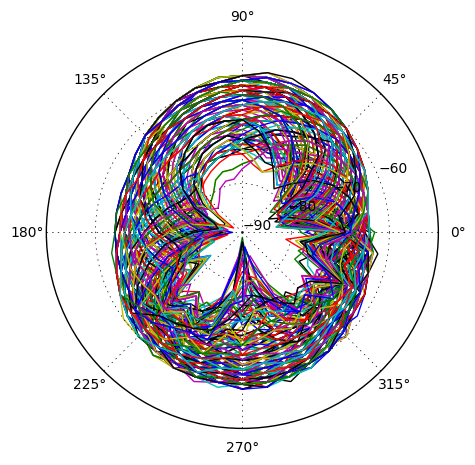

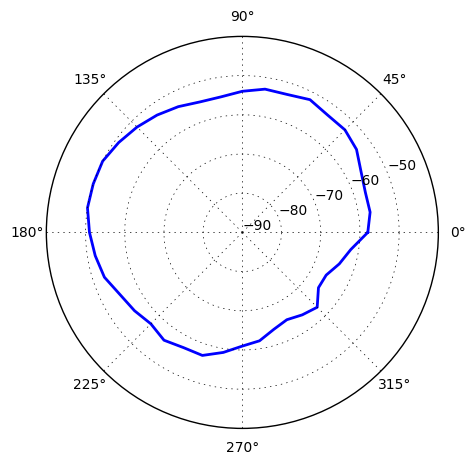

In [8]:
fig = plot_antenna_pattern(node0_antm_df, phase1_range=[160], phase2_range=[0])[0]
plot_antenna_pattern(node0_antm_df, phase1_range=[192,192+32], phase2_range=[192,192+32], figure=fig)
plot_antenna_pattern(node0_antm_df, phase1_range=[192], phase2_range=[192], figure=fig, ls='k-')
plt.ylim(-90,-50)
plt.yticks(np.arange(-90,-50,10))
plt.legend(['(160,0)', '(0,160)'],ncol=2,bbox_to_anchor=(.9, 0))
plt.savefig('figures/patterns/pattern_moteb_antm_160.pdf', bbox_inches='tight')

fig = plot_antenna_pattern(node0_antm_df, phase1_range=[32], phase2_range=[0])[0]
plot_antenna_pattern(node0_antm_df, phase1_range=[0], phase2_range=[32], figure=fig)
plt.legend(['(32,0)', '(0,32)'],ncol=2,bbox_to_anchor=(.9, 0))
plt.ylim(-90,-50)
plt.yticks(np.arange(-90,-50,10))
plt.savefig('figures/patterns/pattern_moteb_antm_32.pdf', bbox_inches='tight')

matplotlib.rcParams['lines.linewidth'] = 1
fig,pairs = plot_antenna_pattern(node0_antm_df, phase1_range=np.arange(0,256), phase2_range=np.arange(0,256))
plt.ylim(-90,-50)
plt.yticks(np.arange(-90,-50,10))
plt.savefig('figures/patterns/pattern_all_all_moteb_antm.pdf', bbox_inches='tight')

matplotlib.rcParams['lines.linewidth'] = 2
fig = plot_telos_pattern(telosb_df[0])
plt.ylim(-90,-40)
plt.yticks(np.arange(-90,-40,10))
plt.savefig('figures/patterns/pattern_telosb.pdf')

-89 -57


array([  0,  16,  32,  48,  64,  80,  96, 112, 128, 144, 160, 176, 192,
       208, 224, 240])

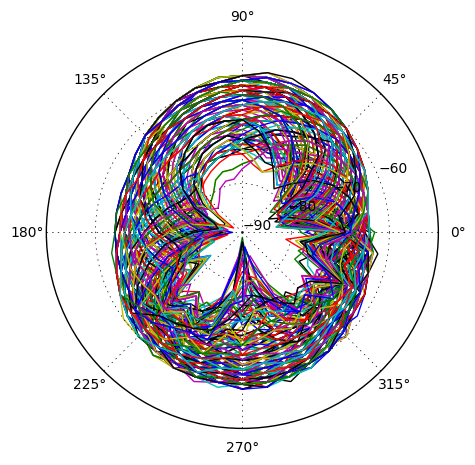

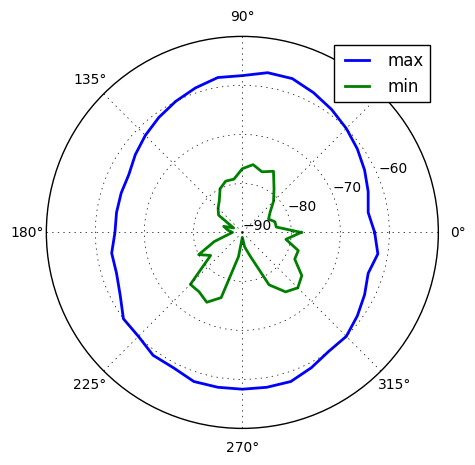

In [19]:
matplotlib.rcParams['lines.linewidth'] = 1
fig0,pairs = plot_antenna_pattern(node0_antm_df, phase1_range=np.arange(0,256), phase2_range=np.arange(0,256))
ax0 = plt.gca()
plt.ylim(-90,-50)
plt.yticks(np.arange(-90,-50,10))
plt.savefig('figures/patterns/pattern_all_all_moteb_antm.pdf', bbox_inches='tight')

matplotlib.rcParams['lines.linewidth'] = 2
fig = plt.figure()
gmax = node0_antm_df.groupby(['angle']).max()
gmin = node0_antm_df.groupby(['angle']).min()
ax = fig.add_axes([0.02, 0.02, 0.98, 0.98], projection='polar')
a = np.array(gmax.index.values) / 200 * np.pi * 2
a = np.append(a, 2 * np.pi)
y = gmax.rssi_avg.values
y = np.append(y, y[0])
ax.plot(a, y)
a = np.array(gmin.index.values) / 200 * np.pi * 2
a = np.append(a, 2 * np.pi)
y = gmin.rssi_avg.values
y = np.append(y, y[0])
ax.plot(a, y)
(m, M) = ax0.get_ylim()
plt.ylim(m, M)
plt.yticks(np.arange(m, M, 10))
plt.legend(['max', 'min'])
plt.savefig('figures/patterns/pattern_all_all_moteb_antm_outter.pdf')

np.unique(node0_antm_df.phase1)


In [20]:
gmax = node0_antm_df.groupby(['angle']).max()
gmax

seq  power  phase  prr  rssi_avg  lqi_avg  rssi_std  lqi_std  phase1  \
angle                                                                           
0        255     31    240  100       -63      107        59      212     240   
5        511     31    240  100       -64      107        79      252     240   
10       767     31    240  100       -63      107        78      283     240   
15      1023     31    240  100       -62      107        70      226     240   
20      1279     31    240  100       -61      107        67      218     240   
25      1535     31    240  100       -60      107        61      215     240   
30      1791     31    240  100       -59      107        55      212     240   
35      2047     31    240  100       -58      107        53      212     240   
40      2303     31    240  100       -57      107        58      213     240   
45      2559     31    240  100       -57      107        50      212     240   
50      2815     31    240  100       -58      107        62      212     240   
55      3071     31    240  100       -58      107        56      213     240   
60      3327     31    240  100       -59      107        65      212     240   
65      3583     31    240  100       -60      107        59      212     240   
70      3839     31    240  100       -61      107        64      212     240   
75      4095     31    240  100       -62      107        58      212     240   
80      4351     31    240  100       -63      107        65      212     240   
85      4607     31    240  100       -64      107        82      330     240   
90      4863     31    240  100       -64      107        77      229     240   
95      5119     31    240  100       -64      107        83      392     240   
100     5375     31    240  100       -64      107        88      300     240   
105     5631     31    240  100       -63      107        88      414     240   
110     5887     31    240  100       -63      107        76      326     240   
115     6143     31    240  100       -62      107        60      212     240   
120     6399     31    240  100       -60      107        77      218     240   
125     6655     31    240  100       -60      107        52      215     240   
130     6911     31    240  100       -59      107        61      214     240   
135     7167     31    240  100       -59      107        55      217     240   
140     7423     31    240  100       -58      107        52      212     240   
145     7679     31    240  100       -58      107        60      212     240   
150     7935     31    240  100       -58      107        82      288     240   
155     8191     31    240  100       -58      107        87      280     240   
160     8447     31    240  100       -58      107        71      242     240   
165     8703     31    240  100       -59      107        57      213     240   
170     8959     31    240  100       -60      107        55      212     240   
175     9215     31    240  100       -60      107        54      212     240   
180     9471     31    240  100       -61      107        58      215     240   
185     9727     31    240  100       -62      107        55      212     240   
190     9983     31    240  100       -63      107        62      212     240   
195    10239     31    240  100       -62      107        63      212     240   

       phase2  line_count  
angle                      
0         240         273  
5         240         533  
10        240         791  
15        240        1048  
20        240        1306  
25        240        1566  
30        240        1826  
35        240        2086  
40        240        2346  
45        240        2606  
50        240        2865  
55        240        3124  
60        240        3384  
65        240        3642  
70        240        3904  
75        240        4164  
80        240        4424  
85        240        4683  
90        240        4940  
95        240     

In [7]:
mote_a = {}
mote_b = {}
mote_c = {}
# mote_cb = {}
mote_d = {}
for node in range(16):
    mote_a[node] = pd.DataFrame.from_csv('/Users/ochipara/Working/DirectionalAntennas/data/testbed/antennapatterns/MoteA_AntennaM/2016-09-24_NODE%d.csv' % node)
    mote_b[node] = pd.DataFrame.from_csv('/Users/ochipara/Working/DirectionalAntennas/data/testbed/antennapatterns/MoteB_AntennaM/2016-09-24_NODE%d.csv' % node)    
    mote_c[node] = pd.DataFrame.from_csv('/Users/ochipara/Working/DirectionalAntennas/data/testbed/antennapatterns/MoteC_AntennaM/2016-09-24_NODE%d.csv' % node)    
#     mote_cb[node] = pd.DataFrame.from_csv('/Users/ochipara/Working/DirectionalAntennas/data/testbed/antennapatterns/MoteC_AntennaM2/2016-09-24_NODE%d.csv' % node)    
    mote_d[node] = pd.DataFrame.from_csv('/Users/ochipara/Working/DirectionalAntennas/data/testbed/antennapatterns/MoteD_AntennaM/2016-09-24_NODE%d.csv' % node)        
    
plt.bar(np.arange(16), [np.mean(mote_a[node].rssi_avg) for node in np.arange(16)],.25, color='k')
plt.bar(np.arange(16)+.25, [np.mean(mote_b[node].rssi_avg) for node in np.arange(16)],.25, color='r')
plt.bar(np.arange(16)+.5, [np.mean(mote_c[node].rssi_avg) for node in np.arange(16)],.25, color='g')
plt.bar(np.arange(16)+.75, [np.mean(mote_d[node].rssi_avg) for node in np.arange(16)],.25, color='b')

plt.ylim([-50, -90])
plt.xlim([0,15])
plt.xticks(np.arange(16) + .45, ['%d' % n for n in range(16)])
plt.xlabel('Node ID')
plt.ylabel('Mean RSSI (dBm)')
plt.legend(['mote-a', 'mote-b', 'mote-c', 'mode-d'], loc='upper right')
plt.savefig('figures/patterns/hw_variation.pdf')


# plt.figure()
# plt.bar(np.arange(16), [np.mean(mote_c[node].rssi_avg) for node in np.arange(16)], .4, color='r')
# plt.bar(np.arange(16)+.4, [np.mean(mote_cb[node].rssi_avg) for node in np.arange(16)], .4, color='b')

OSError: File b'/Users/ochipara/Working/DirectionalAntennas/data/testbed/antennapatterns/MoteA_AntennaM/2016-09-24_NODE0.csv' does not exist

In [46]:
benefit_c = [np.mean(compute_directional_benefit(mote_d[n], 31).benefit) for n in range(16)]
np.mean(benefit_c)

19.087499999999999

Compares the gains of phaser relative to that of the teslob. This is not necessarely a fair comparison since it considers the nodes do not have the same antenna pattern

In [22]:
moteb_antenna_s =  {}
moteb_antenna_m = {}

for node in range(16):
    moteb_antenna_s[node] = pd.DataFrame.from_csv('/Users/ochipara/Working/DirectionalAntennas/data/testbed/antennapatterns/MoteB_AntennaS/2016-09-24_NODE%d.csv' % node)
    moteb_antenna_m[node] = pd.DataFrame.from_csv('/Users/ochipara/Working/DirectionalAntennas/data/testbed/antennapatterns/MoteB_AntennaM/2016-09-24_NODE%d.csv' % node)

In [5]:
plt.bar(np.arange(16), [np.mean(moteb_antenna_s[node].rssi_avg) for node in np.arange(16)],.4, color='k')
plt.bar(np.arange(16)+.4, [np.mean(moteb_antenna_m[node].rssi_avg) for node in np.arange(16)],.4, color='r')
plt.ylim([-50, -80])
plt.xlim([0,16])
plt.xticks(np.arange(16) + .4, ['%d' % n for n in range(16)])
plt.legend(['short antenna', 'long antenna'], loc='lower right')
plt.xlabel('Node ID')
plt.ylabel('Mean RSSI (dBm)')
plt.savefig('figures/patterns/antenna_type_impact.pdf')

NameError: name 'moteb_antenna_s' is not defined

In [6]:
gains_motea_antm_df = {}
gains_motea_antm_dist = []
for node in range(15):
    gains_motea_antm_df[node] = telos_gains(motea_antm_df[node], telosb_df[node])
    gains_motea_antm_dist.append(np.mean(gains_motea_antm_df[node].gain.values))
np.mean(list(gains_motea_antm_dist))

NameError: name 'motea_antm_df' is not defined

** Inteference Benefit **

[the description below raises a bunch of red flags to me, so must be stated more carefully]

The interfence benefit is designed to capture the spatial reuse that may be achieved using the given directional antennas. Consider a receiver $R$ and an interferer $I$. The directional antenna should provide a phase configuration $c$ such that $RSSI(\theta_R, c) - RSSI(\theta_I, c)$ is maximized, where $\theta_R$ and $\theta_I$ indicate the  angles of the receiver $R$ and inteferer $I$ relative to the sender $S$.

$$ max_{c \in C} RSSI(\theta_R, c) - RSS(\theta_I, c) $$

Note that by ensuring a high SNR at the receiver, we are also having a relatively low signal strenght of the interfer. This would enable other nodes to send packets to the interferer. Figure (see below) plots the interference benefit when the reciever is place at relative angle of 0 from the receiver. As expected, close to the angle 0, the gain is low indicating that there is no potential of reuse of interferers that are close to the receiver. Conversely, if the interfer would be located at 90, there is configuration that provides the receiver a gain 25 db.

We define the mean inteference benefit is the mean over pairs of physical angles at which a sender and receiver may be placed. The mean inteference benefit characterizes the expected spatial reuse when nodes would distributed uniformly around the receiver.

In [1]:
[node0_antm_ibenfit, node0_antm_iconfig] = interf_benefit(node0_antm_df)
np.mean(list(node0_antm_ibenfit.values()))
fig = plot_interf_benefit(node0_antm_ibenfit, 0)
(sender_rssi, interf_rssi, phase1, phase2) = node0_antm_iconfig['0-45']
plt.savefig('figures/patterns/interference_benefit_recv0deg.pdf')

plt.figure()
plot_antenna_pattern(node0_antm_df, phase1_range=[phase1], phase2_range=[phase2])
plt.ylim(-90,-50)
plt.yticks(np.arange(-90,-50,10))
plt.plot([0, 0], [-90, -50], 'k-', linewidth=3)
plt.plot([0, np.pi / 2], [-90, -50], 'k-', linewidth=3)
plt.text(0, -50, 'Rcv', bbox=dict(facecolor='red'), fontsize=16)
plt.text((98 / 360) * np.pi * 2, -52, 'Intrf', bbox=dict(facecolor='g'), fontsize=16)
plt.savefig('figures/patterns/interference_benefit_recv0deg_pat.pdf')



NameError: name 'interf_benefit' is not defined

In [ ]:
motea_antm_ibenefit_12 = {}
motea_antm_ibenefit_1 = {}
motea_antm_ibenefit_2 = {}
for node in range(16):
    print('node', node)
    motea_antm_ibenefit_12[node] = interf_benefit(motea_antm_df[node])[0]
    motea_antm_ibenefit_1[node] = interf_benefit(motea_antm_df[node], phase2_range=[0])[0]
    motea_antm_ibenefit_2[node] = interf_benefit(motea_antm_df[node], phase1_range=[0])[0]


node 0
node 1
node 2
node 3


In [ ]:
mean_ibenefit_12 = []
mean_ibenefit_1 = []
mean_ibenefit_2 = []
for node in range(16):
    mean_ibenefit_12.append(np.mean(list(motea_antm_ibenefit_12[node].values())))
    mean_ibenefit_1.append(np.mean(list(motea_antm_ibenefit_1[node].values())))
    mean_ibenefit_2.append(np.mean(list(motea_antm_ibenefit_2[node].values())))
    
plt.bar(np.arange(16), mean_ibenefit_12, .3, color='k')
plt.bar(np.arange(16)+.3, mean_ibenefit_1, .3, color='r')
plt.bar(np.arange(16)+.6, mean_ibenefit_2, .3, color='g')
plt.legend(['all','phaseA fixed', 'phaseB fixed'])
plt.ylim([0,12])
plt.xticks(np.arange(16) + .45, ['%d' % n for n in range(16)])
plt.xlim([0,16])
plt.xlabel('Node ID')
plt.ylabel('Mean interf. benefit')
plt.savefig('figures/patterns/benefit_phase_impact.pdf')


** Directional benefit **


In [11]:
dirbenefit_12 = {}
dirbenefit_1 = {}
dirbenefit_2 = {}
for node in range(16):
    dirbenefit_12[node] = compute_directional_benefit(motea_antm_df[node], 31)
    dirbenefit_1[node] = compute_directional_benefit(motea_antm_df[node], 31, phase1_range=[0])
    dirbenefit_2[node] = compute_directional_benefit(motea_antm_df[node], 31, phase2_range=[0])    

[ 0.          0.15707963  0.31415927  0.4712389   0.62831853  0.78539816
  0.9424778   1.09955743  1.25663706  1.41371669  1.57079633  1.72787596
  1.88495559  2.04203522  2.19911486  2.35619449  2.51327412  2.67035376
  2.82743339  2.98451302  3.14159265  3.29867229  3.45575192  3.61283155
  3.76991118  3.92699082  4.08407045  4.24115008  4.39822972  4.55530935
  4.71238898  4.86946861  5.02654825  5.18362788  5.34070751  5.49778714
  5.65486678  5.81194641  5.96902604  6.12610567]


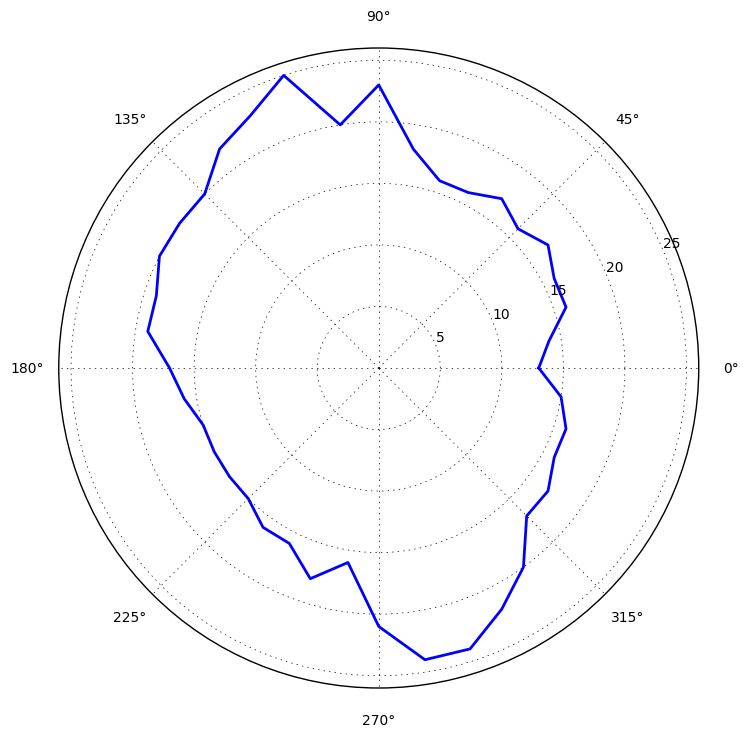

In [12]:
plot_directional_benefit(dirbenefit_12[3])
plt.savefig('figures/patterns/directional_benefit.pdf')
mean_dirbenefit_12 = [np.mean(dirbenefit_12[x].benefit) for x in range(16)]
mean_dirbenefit_1 = [np.mean(dirbenefit_1[x].benefit) for x in range(16)]
mean_dirbenefit_2 = [np.mean(dirbenefit_2[x].benefit) for x in range(16)]

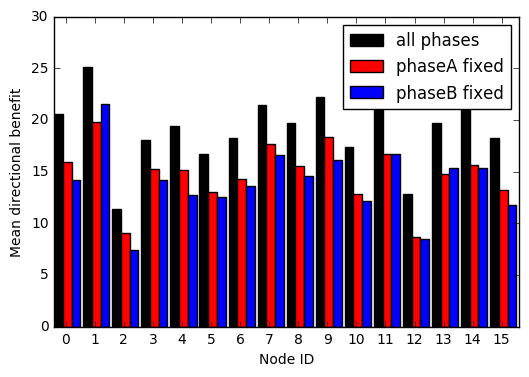

In [13]:
plt.bar(np.arange(16), mean_dirbenefit_12, .3, color='k')
plt.bar(np.arange(16) + .3, mean_dirbenefit_1, .3, color='r')
plt.bar(np.arange(16) + .6, mean_dirbenefit_2, .3, color='b')
plt.legend(['all phases', 'phaseA fixed', 'phaseB fixed'])
plt.xticks(np.arange(16) + .4, ['%d' % n for n in range(16)])
plt.xlabel('Node ID')
plt.ylabel('Mean directional benefit')


** Comparison with Santa **

[ 0.          0.15707963  0.31415927  0.4712389   0.62831853  0.78539816
  0.9424778   1.09955743  1.25663706  1.41371669  1.57079633  1.72787596
  1.88495559  2.04203522  2.19911486  2.35619449  2.51327412  2.67035376
  2.82743339  2.98451302  3.14159265  3.29867229  3.45575192  3.61283155
  3.76991118  3.92699082  4.08407045  4.24115008  4.39822972  4.55530935
  4.71238898  4.86946861  5.02654825  5.18362788  5.34070751  5.49778714
  5.65486678  5.81194641  5.96902604  6.12610567]


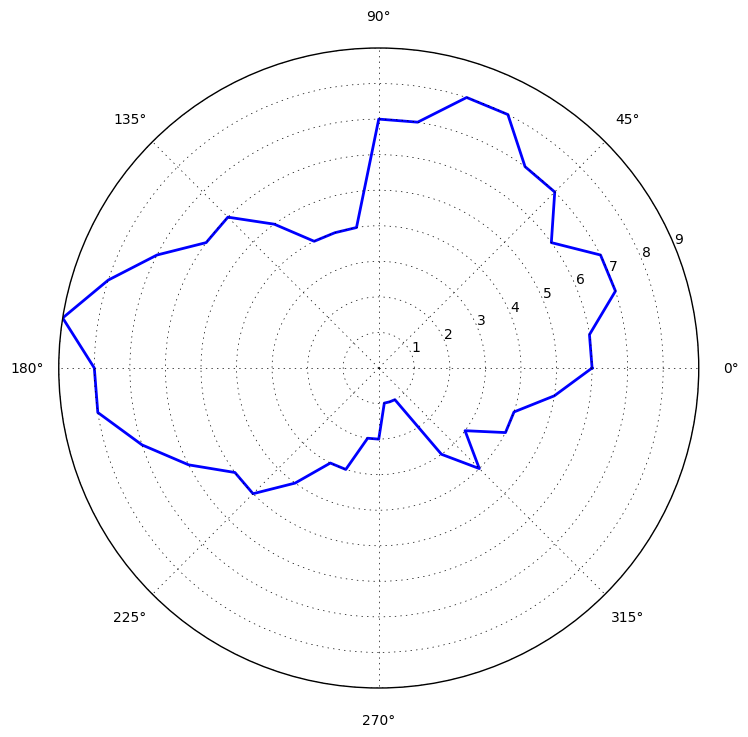

In [21]:
from leo import ingest
santab = ingest('/Users/ochipara/Working/DirectionalAntennas/data/leo/santa_o718b.csv')
santab = santab[santab.power == 31]
santab.columns = ['seq','power','angle','phase','prr','rssi_avg','lqi_avg','rssi_std','lqi_std']
santab_benefit = compute_directional_benefit(santab, 31)

plot_directional_benefit(santab_benefit)



